In [1]:
!pip install -q Kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayabarakat","key":"e713bac6d1496bd4edd1a001eb3829eb"}'}

In [3]:
! mkdir ~/.Kaggle

In [4]:
! cp kaggle.json ~/.Kaggle/

In [5]:
! chmod 600 ~/.Kaggle/kaggle.json

In [6]:
! kaggle datasets download -d ananthu017/emotion-detection-fer

Dataset URL: https://www.kaggle.com/datasets/ananthu017/emotion-detection-fer
License(s): CC0-1.0
 57% 37.0M/65.2M [00:00<00:00, 191MB/s] 
100% 65.2M/65.2M [00:00<00:00, 212MB/s]


In [7]:
! unzip emotion-detection-fer.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/im37.png      
  inflating: train/sad/im370.png     
  inflating: train/sad/im3700.png    
  inflating: train/sad/im3701.png    
  inflating: train/sad/im3702.png    
  inflating: train/sad/im3703.png    
  inflating: train/sad/im3704.png    
  inflating: train/sad/im3705.png    
  inflating: train/sad/im3706.png    
  inflating: train/sad/im3707.png    
  inflating: train/sad/im3708.png    
  inflating: train/sad/im3709.png    
  inflating: train/sad/im371.png     
  inflating: train/sad/im3710.png    
  inflating: train/sad/im3711.png    
  inflating: train/sad/im3712.png    
  inflating: train/sad/im3713.png    
  inflating: train/sad/im3714.png    
  inflating: train/sad/im3715.png    
  inflating: train/sad/im3716.png    
  inflating: train/sad/im3717.png    
  inflating: train/sad/im3718.png    
  inflating: train/sad/im3719.png    
  inflating: train/sad/im372.png     
  inflating: train/sad/im3720.png    

In [1]:
import numpy as np
import pandas as pd
import io
import os
from matplotlib import image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import seaborn as sns
from imgaug import augmenters as iaa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import NASNetLarge
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
df_train=r'D:\AMIT\Project\PROJECT_AYA\Dataset\train'
labels_train = os.listdir(df_train)
labels_train

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

In [3]:
df_test=r'D:\AMIT\Project\PROJECT_AYA\Dataset\test'
labels_test = os.listdir(df_test)
labels_test

['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']

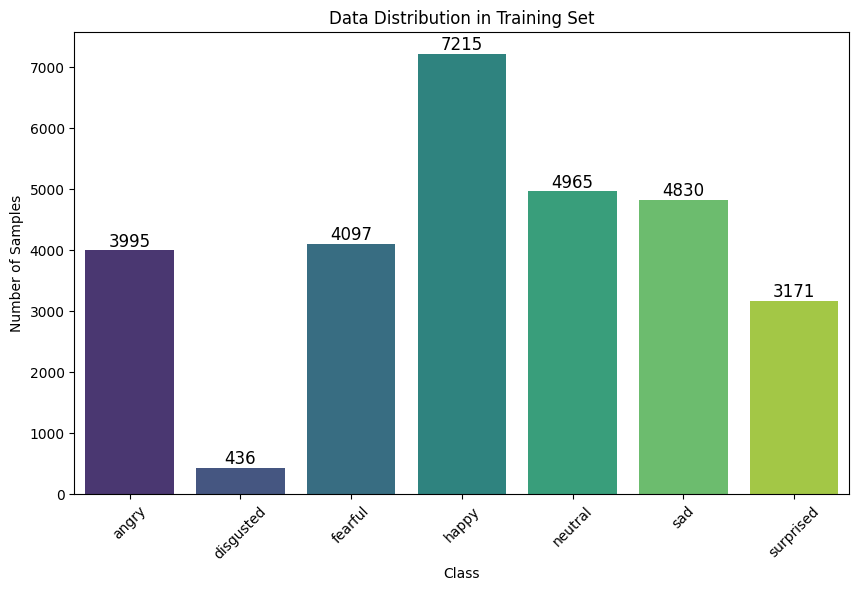

In [4]:

def plot_data_distribution(folder_path):
    class_folders = os.listdir(folder_path)

    class_counts = {class_name: len(os.listdir(os.path.join(folder_path, class_name))) for class_name in class_folders}

    class_names = list(class_counts.keys())
    counts = list(class_counts.values())


    plt.figure(figsize=(10, 6))
    sns.barplot(x=class_names, y=counts, palette="viridis")

    for i, count in enumerate(counts):
        plt.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=12, color='black')

    plt.title('Data Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    plt.show()


plot_data_distribution(df_train)



In [5]:
# Define the input and output directories
input_directory = r'D:\AMIT\Project\PROJECT_AYA\Dataset\train\disgusted'
output_directory = r'D:\AMIT\Project\PROJECT_AYA\Dataset\train\disgusted'

# Create the output directory if it doesn't exist
os.makedirs(output_directory, exist_ok=True)

# Define the augmentation sequence
seq = iaa.Sequential([
    iaa.Fliplr(0.5),  # 50% horizontally flip
    iaa.Affine(rotate=(-45, 45)),  # rotate images by -45 to 45 degrees
    iaa.GaussianBlur(sigma=(0, 3.0)),  # apply gaussian blur with a sigma between 0 and 3.0
    iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255)),  # add Gaussian noise
    iaa.Multiply((0.5, 1.5), per_channel=0.5),  # multiply brightness
], random_order=True)

# List all image files in the input directory
image_files = [f for f in os.listdir(input_directory) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Augment and save each image
for image_file in image_files:
    # Load the image
    image_path = os.path.join(input_directory, image_file)
    img = cv2.imread(image_path)

    # Apply augmentation
    augmented_images = [seq.augment_image(img) for _ in range(9)]  # Augment the image n times

    # Save augmented images
    base_filename, file_extension = os.path.splitext(image_file)
    for i, augmented_img in enumerate(augmented_images):
        output_path = os.path.join(output_directory, f"{base_filename}_aug_{i}{file_extension}")
        cv2.imwrite(output_path, augmented_img)

print("Augmentation complete.")

Augmentation complete.


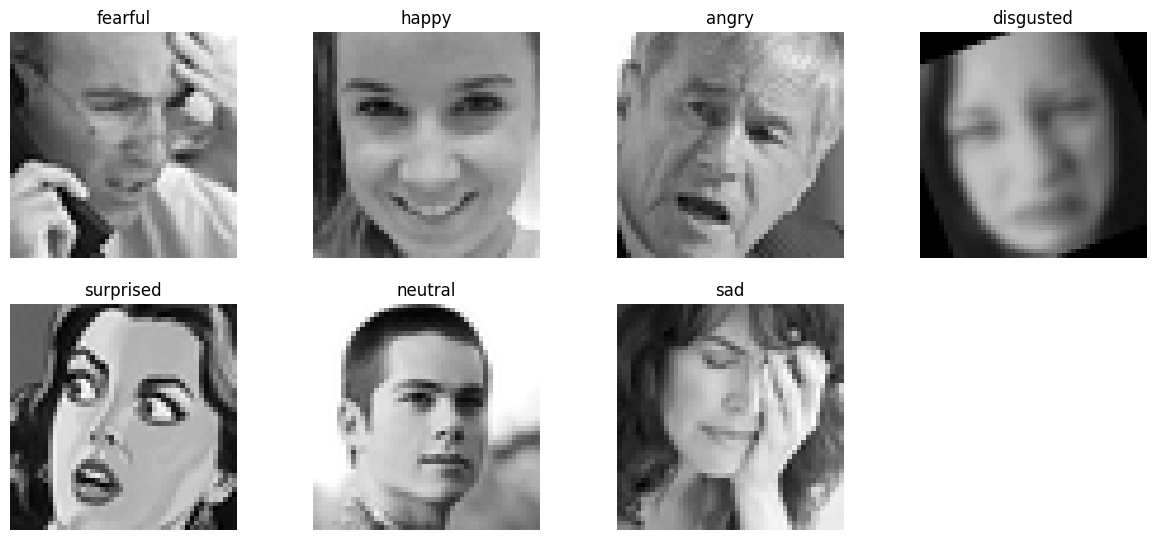

In [13]:
# Visualizing one image for every class label
emotions=os.listdir(df_train)
plt.figure(figsize=(15,10))
for i,emotion in enumerate(emotions,1):
    folder=os.path.join(df_train,emotion)
    img_path=os.path.join(folder,os.listdir(folder)[6])
    img=plt.imread(img_path)
    plt.subplot(3,4,i)
    plt.imshow(img,cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [4]:
def count_images_in_classes(dataset_dir):
    class_counts = {}
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

class_counts = count_images_in_classes(df_train)
print(f"Class distribution  {class_counts}")

Class distribution  {'angry': 3995, 'disgusted': 4360, 'fearful': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprised': 3171}


In [5]:
from PIL import Image

#data preprocessing
images = []
labels = []

for emotion_folder in os.listdir(df_train):
    if os.path.isdir(os.path.join(df_train, emotion_folder)):
        for image_file in os.listdir(os.path.join(df_train, emotion_folder)):
            # Load image
            image_path = os.path.join(df_train, emotion_folder, image_file)
            image = Image.open(image_path) # Open the image
            image = image.convert("L")  # Ensure the image is in grayscale 
            image = image.resize((48, 48))  # Resize
            image = np.array(image) / 255.0 # Normalize pixel values
            image = np.stack((image,)*3, axis=-1)   # Convert to 3 channels for mobilenet
            images.append(image)
            labels.append(emotion_folder)  # Use folder name (emotion) as label

images, labels = np.array(images), np.array(labels)

print(labels)


['angry' 'angry' 'angry' ... 'surprised' 'surprised' 'surprised']


In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Convert labels to numerical values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

labels = to_categorical(labels)

print(images.shape)
print(labels.shape)

(32633, 48, 48, 3)
(32633, 7)


In [7]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42,stratify=labels)

In [8]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

# Specify the input shape for the model
input_shape = (48, 48, 3)  # Adjust the input size as needed

# Load the mobilenet model pre-trained on ImageNet
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

# Create a new model using the mobilenet base model
model = Sequential()

# Add the mobilenet base model
model.add(base_model)

# Add a global average pooling layer to reduce the spatial dimensions
model.add(GlobalAveragePooling2D())

# Add a dense layer for classification
model.add(Dense(units=7, activation='softmax'))  #7---->>num classes


# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functi  (None, 1, 1, 1024)        3228864   
 onal)                                                           
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 7)                 7175      
                                                                 
Total params: 3236039 (12.34 MB)
Trainable params: 3214151 (12.26 MB)
Non-trainable params: 21888 (85.50 KB)
_________________________________________________________________


In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model_history = model.fit(train_images, train_labels, epochs=40, batch_size=32, validation_data=(test_images, test_labels),verbose=1, callbacks=[early_stopping])                        

Epoch 1/40


816/816 [==============================] - 73s 85ms/step - loss: 1.5176 - accuracy: 0.4689 - val_loss: 1.4560 - val_accuracy: 0.4944
Epoch 2/40
816/816 [==============================] - 66s 80ms/step - loss: 1.1707 - accuracy: 0.5654 - val_loss: 1.0843 - val_accuracy: 0.5958
Epoch 3/40
816/816 [==============================] - 65s 80ms/step - loss: 1.1640 - accuracy: 0.5799 - val_loss: 1.2437 - val_accuracy: 0.5588
Epoch 4/40
816/816 [==============================] - 65s 80ms/step - loss: 1.1090 - accuracy: 0.5956 - val_loss: 1.0734 - val_accuracy: 0.6017
Epoch 5/40
816/816 [==============================] - 64s 79ms/step - loss: 1.2689 - accuracy: 0.5520 - val_loss: 1.1539 - val_accuracy: 0.5617
Epoch 6/40
816/816 [==============================] - 65s 80ms/step - loss: 1.0771 - accuracy: 0.5984 - val_loss: 1.0247 - val_accuracy: 0.6194
Epoch 7/40
816/816 [==============================] - 66s 81ms/step - loss: 0.9665 - accuracy: 0.6448 - val_loss: 1.0197 - val_accurac

In [10]:
model.save('model_63.86.h5')

In [11]:
loss, accuracy = model.evaluate(test_images, test_labels)

204/204 [==============================] - 4s 20ms/step - loss: 0.9696 - accuracy: 0.6432


204/204 [==============================] - 5s 20ms/step


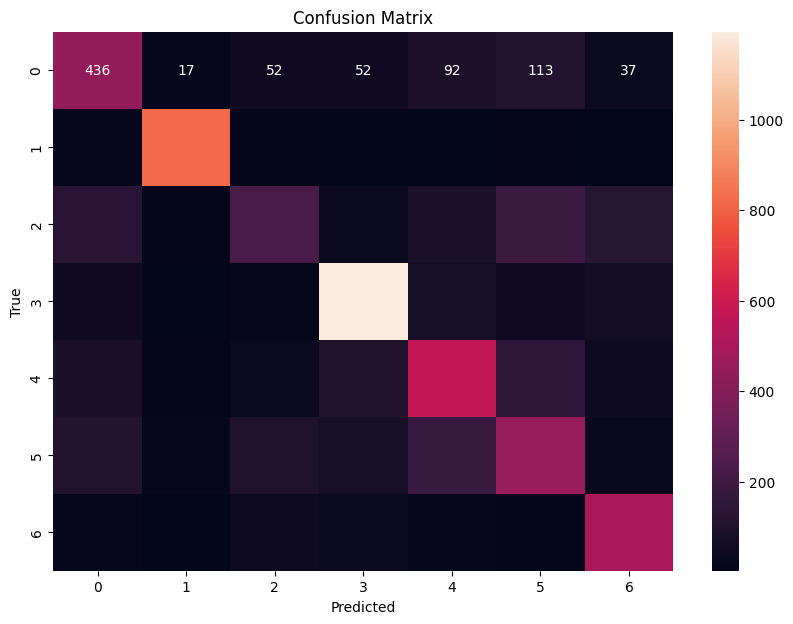

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Make predictions on test data
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_labels, axis=1)
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize confusion matrix using seaborn and matplotlib
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[ 436   17   52   52   92  113   37]
 [  20  819   11    4    3   10    5]
 [ 130   13  229   40   89  191  128]
 [  51    3   19 1194   66   51   59]
 [  85    9   38   98  568  152   43]
 [ 112   17   99   74  183  452   29]
 [  21    3   44   39   19    8  500]]


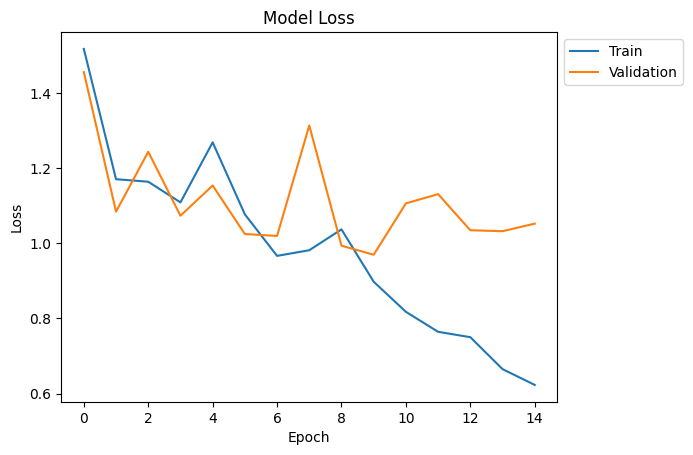

In [15]:
# Summarize history for loss

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

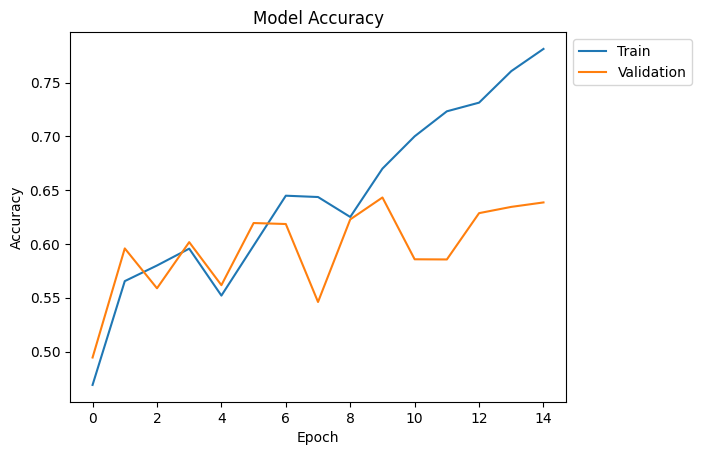

In [16]:
# Summarize history for accuracy

plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left', bbox_to_anchor=(1,1))
plt.show()

In [18]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.51      0.55      0.53       799
           1       0.93      0.94      0.93       872
           2       0.47      0.28      0.35       820
           3       0.80      0.83      0.81      1443
           4       0.56      0.57      0.56       993
           5       0.46      0.47      0.47       966
           6       0.62      0.79      0.70       634

    accuracy                           0.64      6527
   macro avg       0.62      0.63      0.62      6527
weighted avg       0.63      0.64      0.63      6527



In [19]:
loaded_model = tf.keras.models.load_model('model_63.86.h5')

1/1 [==============================] - 0s 24ms/step
Image: im0.png


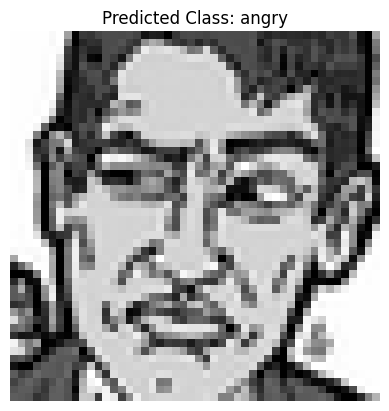

1/1 [==============================] - 0s 24ms/step
Image: im1.png


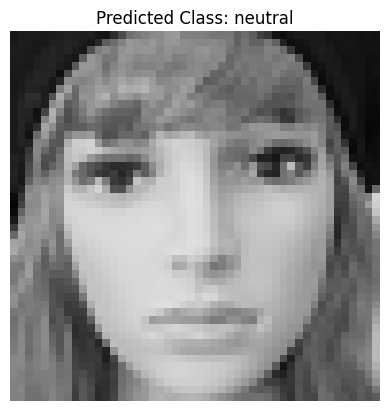

1/1 [==============================] - 0s 29ms/step
Image: im10.png


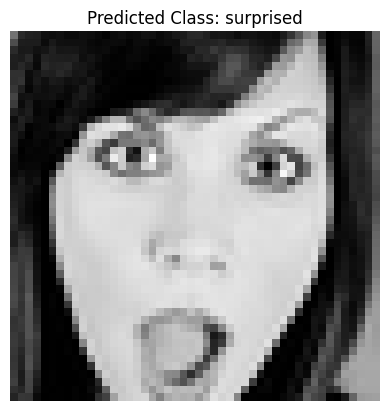

1/1 [==============================] - 0s 23ms/step
Image: im160.png


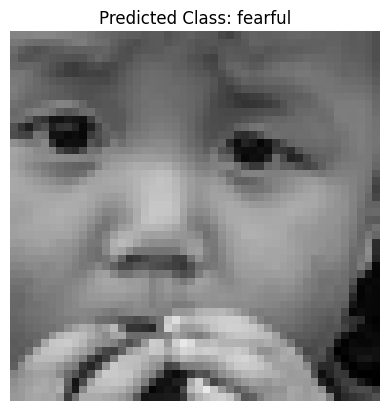

1/1 [==============================] - 0s 28ms/step
Image: im2.png


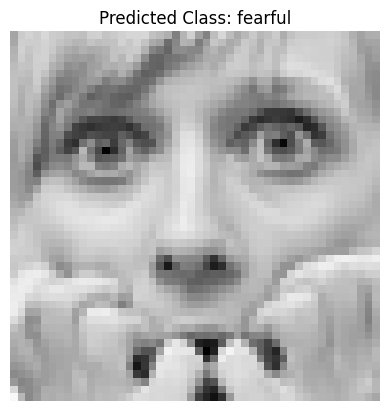

1/1 [==============================] - 0s 25ms/step
Image: im20.png


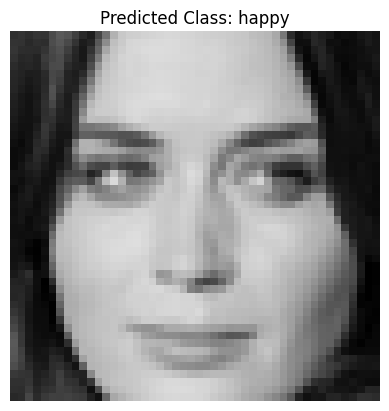

1/1 [==============================] - 0s 23ms/step
Image: im259.png


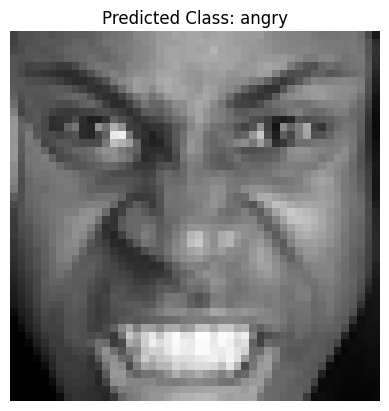

1/1 [==============================] - 0s 22ms/step
Image: im26.png


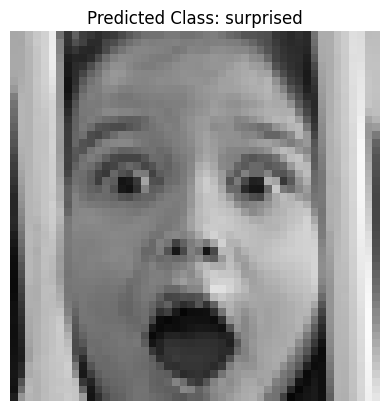

1/1 [==============================] - 0s 23ms/step
Image: im27.png


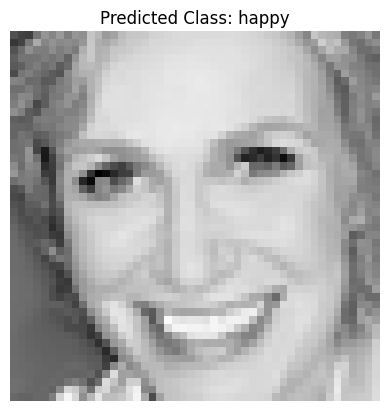

1/1 [==============================] - 0s 22ms/step
Image: im35.png


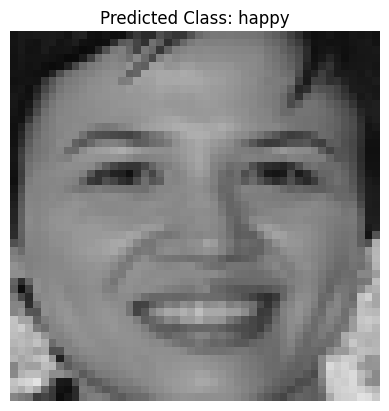

1/1 [==============================] - 0s 23ms/step
Image: im381.png


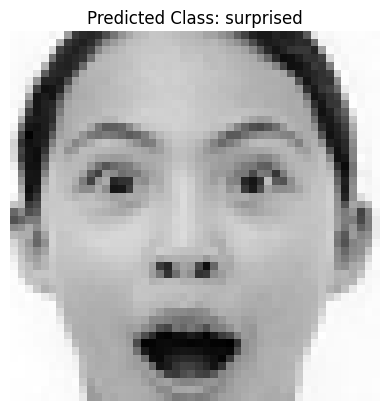

1/1 [==============================] - 0s 25ms/step
Image: im481.png


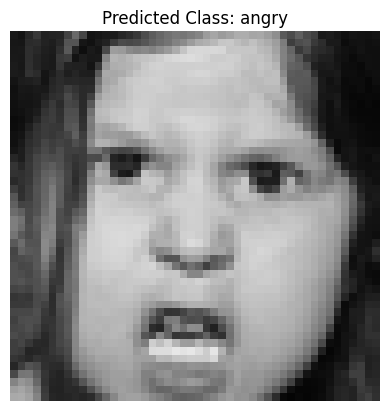

1/1 [==============================] - 0s 23ms/step
Image: im49.png


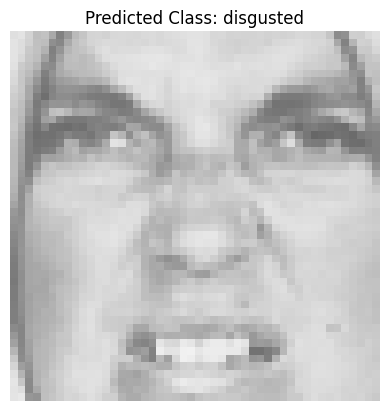

1/1 [==============================] - 0s 23ms/step
Image: im6.png


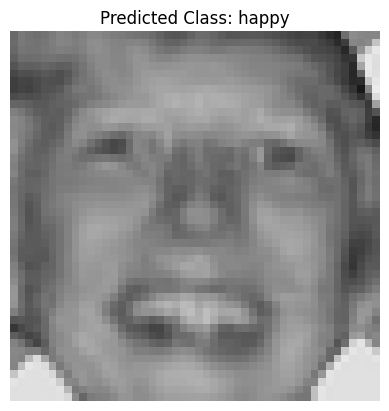

1/1 [==============================] - 0s 23ms/step
Image: im7.png


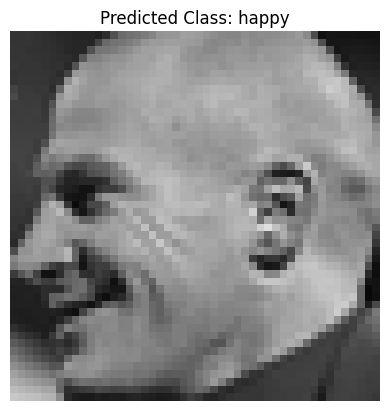

1/1 [==============================] - 0s 22ms/step
Image: im79.png


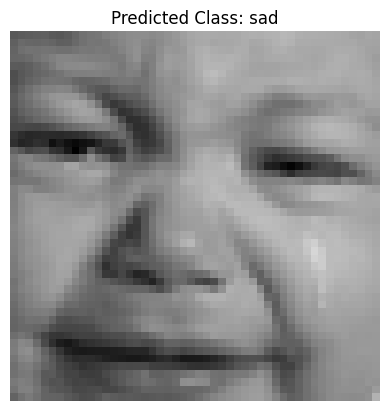

1/1 [==============================] - 0s 23ms/step
Image: im90.png


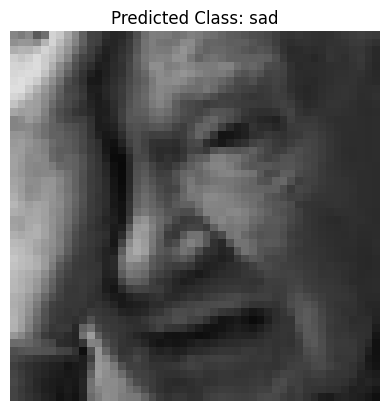

In [39]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model


# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    image = Image.open(image_path) # Open the image
    image = image.convert("L")  # Ensure the image is in grayscale 
    image = image.resize((48, 48))  # Resize
    image = np.array(image) / 255.0 # Normalize pixel values
    image = np.stack((image,)*3, axis=-1)   # Convert to 3 channels for mobilenet 
    return image
 

# Folder containing test images
test_folder = r'D:\AMIT\Project\Dataset\test\2'

label_mapping = {class_index: class_label for class_index, class_label in enumerate(label_encoder.classes_)}

# Iterate through the images in the folder
for image_file in os.listdir(test_folder):
    image_path = os.path.join(test_folder, image_file)
    
    # Preprocess the image
    image = preprocess_image(image_path)
    
    # Perform prediction
    predictions = model.predict(np.array([image]))
    predicted_class_index = np.argmax(predictions)
    
    # Get the predicted class label in string format
    predicted_class_label = label_mapping[predicted_class_index]
    
    # Display the original image filename
    print(f'Image: {image_file}')

    # Display the image along with its predicted class
    plt.imshow(cv2.imread(image_path))
    plt.title(f'Predicted Class: {predicted_class_label}')
    plt.axis('off')
    plt.show()


In [35]:
def preprocess_image(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Open the image
    # image = image.convert("L")  # Ensure the image is in grayscale 
    image = image.resize((48, 48))  # Resize
    image = (image) / 255.0 # Normalize pixel values
    image = np.stack((image,)*3, axis=-1)   # Convert to 3 channels for mobilenet
    return image

In [36]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

# Load an image for testing
image_path = r'D:\AMIT\Project\PROJECT_AYA\Dataset\test\angry/im100.png'
img = image.load_img(image_path, target_size=(48, 48))


# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data augmentation settings
preprocessed_img = preprocess_image(image_path)

# Make prediction
prediction = loaded_model.predict(preprocessed_img)

# Get predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

# Display the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class label
plt.title("Predicted class: " + predicted_class_label)
plt.show()


TypeError: unsupported operand type(s) for /: 'NoneType' and 'float'

1/1 [==============================] - 0s 36ms/step
Predicted class: happy


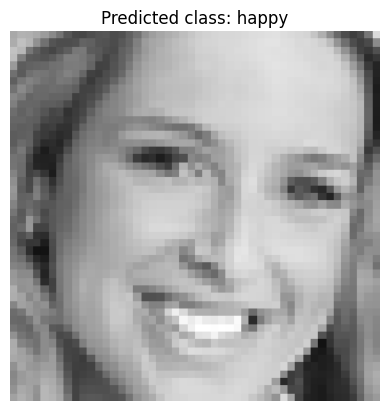

In [ ]:
from keras.preprocessing import image

# Load an image for testing
image_path = '/content/test/happy/im1004.png'
img = image.load_img(image_path, target_size=(256, 256))

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data augmentation settings
preprocessed_img = datagen.standardize(img_array)

# Make prediction
prediction = loaded_model.predict(preprocessed_img)

# Get predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)
# Display the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class label
plt.title("Predicted class: " + predicted_class_label)
plt.show()



1/1 [==============================] - 0s 35ms/step
Predicted class: surprised


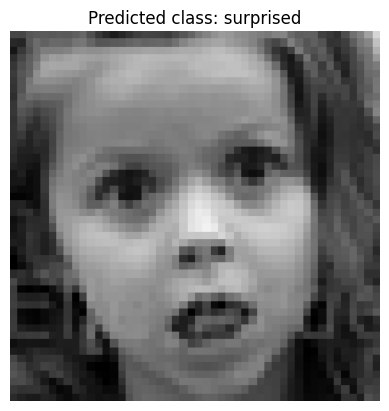

In [ ]:
from keras.preprocessing import image

# Load an image for testing
image_path = '/content/test/surprised/im100.png'
img = image.load_img(image_path, target_size=(256, 256))

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data augmentation settings
preprocessed_img = datagen.standardize(img_array)

# Make prediction
prediction = loaded_model.predict(preprocessed_img)

# Get predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)
# Display the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class label
plt.title("Predicted class: " + predicted_class_label)
plt.show()



1/1 [==============================] - 0s 30ms/step
Predicted class: sad


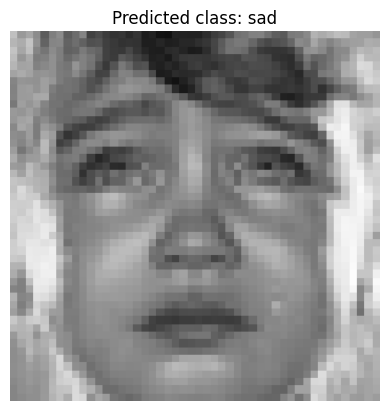

In [ ]:
from keras.preprocessing import image

# Load an image for testing
image_path = '/content/test/sad/im1025.png'
img = image.load_img(image_path, target_size=(256, 256))

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data augmentation settings
preprocessed_img = datagen.standardize(img_array)

# Make prediction
prediction = loaded_model.predict(preprocessed_img)

# Get predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)
# Display the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class label
plt.title("Predicted class: " + predicted_class_label)
plt.show()



1/1 [==============================] - 0s 34ms/step
Predicted class: disgusted


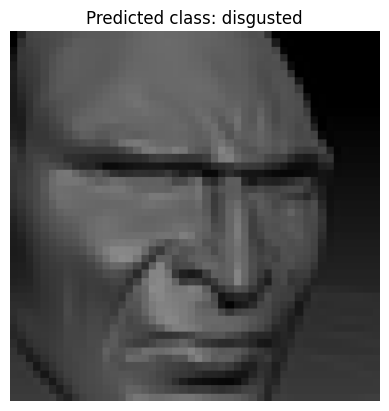

In [ ]:
from keras.preprocessing import image

# Load an image for testing
image_path = '/content/test/disgusted/im90.png'
img = image.load_img(image_path, target_size=(256, 256))

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data augmentation settings
preprocessed_img = datagen.standardize(img_array)

# Make prediction
prediction = loaded_model.predict(preprocessed_img)

# Get predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)
# Display the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class label
plt.title("Predicted class: " + predicted_class_label)
plt.show()



1/1 [==============================] - 0s 30ms/step
Predicted class: fearful


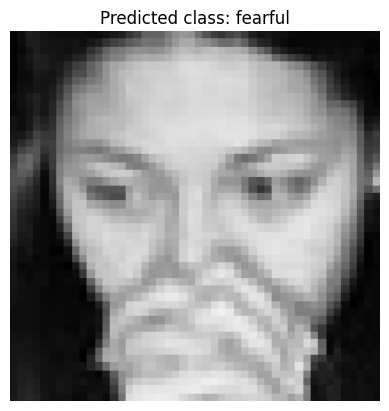

In [ ]:
from keras.preprocessing import image

# Load an image for testing
image_path = '/content/test/fearful/im114.png'
img = image.load_img(image_path, target_size=(256, 256))

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data augmentation settings
preprocessed_img = datagen.standardize(img_array)

# Make prediction
prediction = loaded_model.predict(preprocessed_img)

# Get predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)
# Display the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class label
plt.title("Predicted class: " + predicted_class_label)
plt.show()



1/1 [==============================] - 0s 70ms/step
Predicted class: neutral


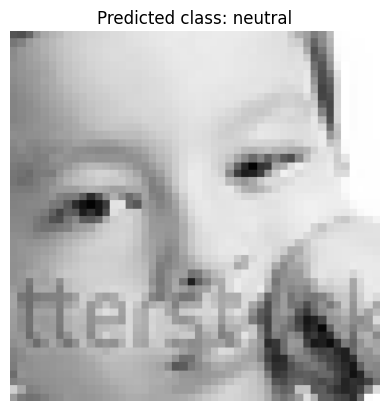

In [ ]:
from keras.preprocessing import image

# Load an image for testing
image_path = '/content/test/neutral/im1003.png'
img = image.load_img(image_path, target_size=(256, 256))

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data augmentation settings
preprocessed_img = datagen.standardize(img_array)

# Make prediction
prediction = loaded_model.predict(preprocessed_img)

# Get predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)
# Display the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class label
plt.title("Predicted class: " + predicted_class_label)
plt.show()



1/1 [==============================] - 0s 35ms/step
Predicted class: fearful


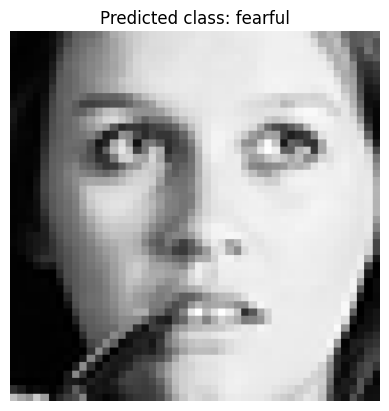

In [ ]:
from keras.preprocessing import image

# Load an image for testing
image_path = '/content/test/fearful/im1016.png'
img = image.load_img(image_path, target_size=(256, 256))

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data augmentation settings
preprocessed_img = datagen.standardize(img_array)

# Make prediction
prediction = loaded_model.predict(preprocessed_img)

# Get predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)
# Display the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class label
plt.title("Predicted class: " + predicted_class_label)
plt.show()



1/1 [==============================] - 0s 30ms/step
Predicted class: angry


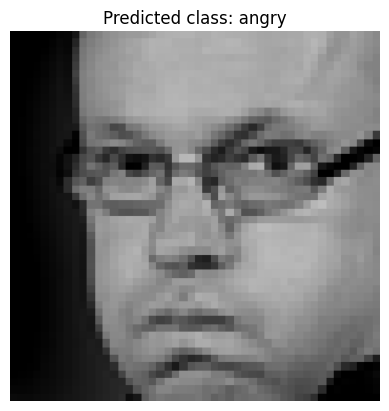

In [ ]:
from keras.preprocessing import image

# Load an image for testing
image_path = '/content/test/angry/im106.png'
img = image.load_img(image_path, target_size=(256, 256))

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data augmentation settings
preprocessed_img = datagen.standardize(img_array)

# Make prediction
prediction = loaded_model.predict(preprocessed_img)

# Get predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)
# Display the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class label
plt.title("Predicted class: " + predicted_class_label)
plt.show()



1/1 [==============================] - 0s 31ms/step
Predicted class: surprised


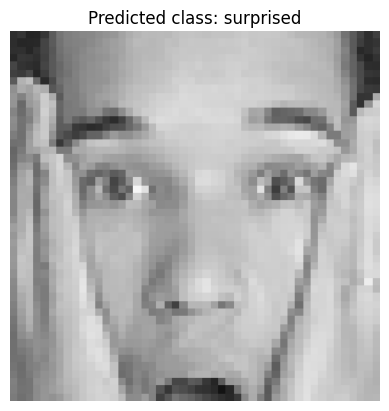

In [ ]:
from keras.preprocessing import image

# Load an image for testing
image_path = '/content/test/surprised/im102.png'
img = image.load_img(image_path, target_size=(256, 256))

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data augmentation settings
preprocessed_img = datagen.standardize(img_array)

# Make prediction
prediction = loaded_model.predict(preprocessed_img)

# Get predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)
# Display the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class label
plt.title("Predicted class: " + predicted_class_label)
plt.show()



1/1 [==============================] - 0s 39ms/step
Predicted class: angry


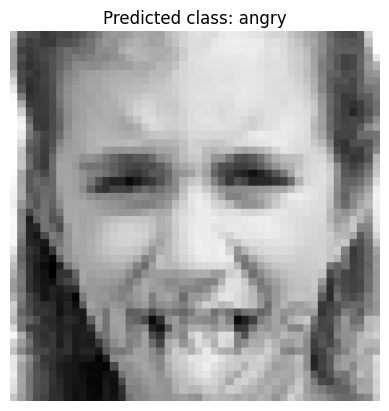

In [ ]:
from keras.preprocessing import image

# Load an image for testing
image_path = '/content/test/disgusted/im104.png'
img = image.load_img(image_path, target_size=(256, 256))

# Convert the image to an array
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image using the same data augmentation settings
preprocessed_img = datagen.standardize(img_array)

# Make prediction
prediction = loaded_model.predict(preprocessed_img)

# Get predicted class label
predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]

# Print the predicted class label
print("Predicted class:", predicted_class_label)
# Display the image
plt.imshow(img)
plt.axis('off')

# Print the predicted class label
plt.title("Predicted class: " + predicted_class_label)
plt.show()

